<a href="https://www.kaggle.com/code/itsabhijith/loan-defaulter-sampling-modeling?scriptVersionId=157997666" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<hr>
    <h1 style='font-family:verdana;text-align:center'>🏦Loan Defaulter Credit Risk Analytics - Sampling techniques and penalizing algorithms</h1>
<hr>
<p> 
    If you'd like to check out the EDA and preprocessing notebook, 
    <a href="https://www.kaggle.com/code/itsabhijith/loan-defaulter-analytics-eda-preprocessing">please click here.</a><br>
    
The objective of this kernel is to experiment with sampling techniques and cost sensitive learning. I have referred to the following blogs to try out different methods:<br>
    <ul>
        <li>
            <a href="https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/">Blog 1</a> - This post covers choosing the right metrics, using imblearn for sampling, and implementing penalized learning algorithms.
        </li>
        <li>
            <a href="https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a">Blog 2</a> - Again, imblearn sampling techniques are included with a couple of extra algorithms, not covered in Blog 1. Additionally, there are visualizations to describe the working of the classifiers. 
        </li>
        <li>
            <a href="https://medium.com/@data.pilot/7-techniques-to-handle-class-imbalance-in-machine-learning-eb1297419ec9#:~:text=Ensemble%20techniques%20such%20as%20Bagging,to%20capture%20minority%20class%20patterns.">Blog 3</a> - Topics unique to this post are: Generating synthetic data using Autoencoders and One-class classification approaches using IsolationForest and One-Class SVM.
        </li>
        <li>
            <a href="https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/">Blog 4</a> - Discusses threshold moving for imbalanced classification. 
        </li>
        <li> 
            <a href="https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3">Blog 5</a> - Similar to Blog 4, elaborates on metrics and thresholding tuning.
        </li>
        <li>
            <a href="https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3">Blog 6 </a> - A continuation of Blogs 4 and 5
        </li>
   </ul>
</p>

In [1]:
import numpy as np 
import pandas as pd
import copy
import optuna
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics
from imblearn import under_sampling, over_sampling

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/application-df-preprocessed/application_df_preprocessed.csv
/kaggle/input/loan-defaulter/application_data.csv
/kaggle/input/loan-defaulter/previous_application.csv
/kaggle/input/loan-defaulter/columns_description.csv


In [2]:
application_df = pd.read_csv('/kaggle/input/application-df-preprocessed/application_df_preprocessed.csv')

In [3]:
application_df = application_df.dropna() 

In [4]:
X = application_df.drop(['Unnamed: 0','TARGET'],axis=1)
Y = application_df.TARGET

In [5]:
Y.value_counts()

TARGET
0    279858
1     24667
Name: count, dtype: int64

<h4>Roughly 91% of the target belongs to class 0 while 9% of the data belongs to class 1</h4> 

In [6]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=1)

In [7]:
robust_scaler = preprocessing.RobustScaler()

In [8]:
X_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Client_Age']] = robust_scaler.fit_transform(X_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Client_Age']])

In [9]:
X_test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Client_Age']] = robust_scaler.fit_transform(X_test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Client_Age']])

<h2> Sampling Techniques - Applied only after splitting the data into train and test sets </h2>
<p> There are two main methods to perform sampling - Undersampling and Oversampling.<br>
    <b><u>Undersampling:</u></b>  Here, records of the majority class are randomly selected to match those of the minority class. <br>
    <b>Techniques -</b> RandomUnderSampler, TomekLinks, NearMiss<br>
    <b>Cons - Loss of information.</b><br><br>
    <b><u>Oversampling:</u></b>  Here, records of the minority class are duplicated/synthetically generated to match those of the majority class. <br>
    <b>Techniques -</b> RandomOverSampler, SMOTE<br>
    <b>Cons - Overfitting.</b><br>
    

<h3> Building models on the original data</h3><br>
<p> I will start with logistic regression before trying ensemble algorithms like Random Forest or XGBoost.</p>

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
def display_confusion_matrix(Y_test,Y_pred):
    plt.figure(figsize=(12,6))
    cm = metrics.confusion_matrix(Y_test,Y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(cm)
    cm_display.plot()
    plt.show()

In [12]:
def plot_roc_curve(Y_test,Y_pred):
    fpr,tpr,threshold = metrics.roc_curve(Y_test,Y_pred)
    plt.figure(figsize=(12,4))
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
    plt.plot([1,0], [1,1], linestyle='--', label='Best')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [13]:
logit_clf_balanced = LogisticRegression(solver='newton-cholesky',class_weight='balanced').fit(X_train,Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.27353e-17): result may not be accurate.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [14]:
Y_pred_balanced = logit_clf_balanced.predict(X_test)

In [15]:
print(metrics.classification_report(Y_test,Y_pred_balanced))

              precision    recall  f1-score   support

           0       0.94      0.52      0.67     55972
           1       0.10      0.61      0.17      4933

    accuracy                           0.53     60905
   macro avg       0.52      0.57      0.42     60905
weighted avg       0.87      0.53      0.63     60905



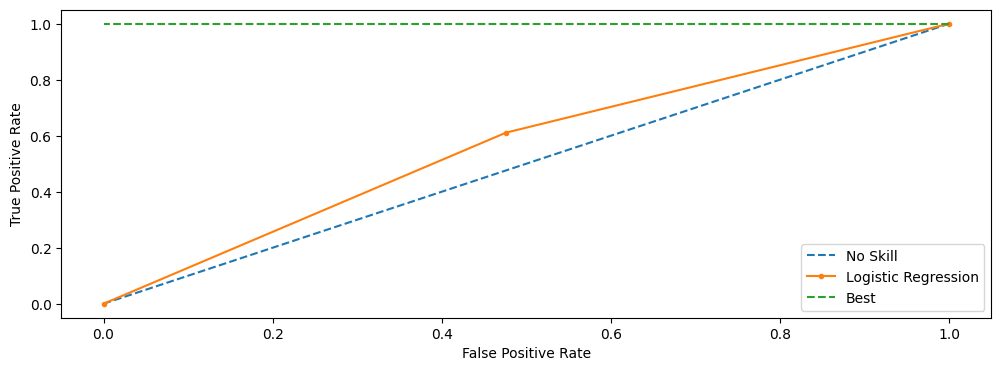

In [16]:
plot_roc_curve(Y_test,Y_pred_balanced)

<Figure size 1200x600 with 0 Axes>

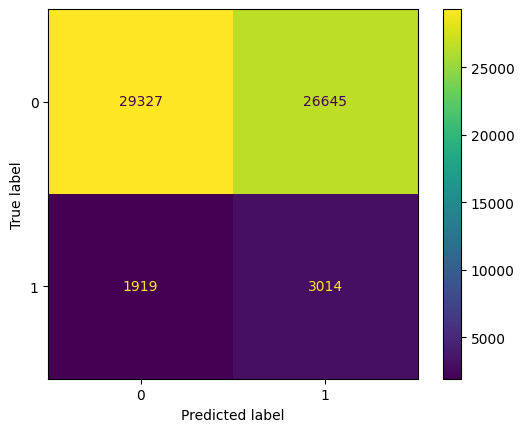

In [17]:
display_confusion_matrix(Y_test,Y_pred_balanced)

<h4> Tuning the classifier </h4>

In [18]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        #'penalty':trial.suggest_categorical('penalty',['l1','l2','elasticnet','none']),
        'C':trial.suggest_float('C',0.001,2),
        'tol':trial.suggest_float('tol' , 1e-6 , 1e-2),
        'class_weight':'balanced',
        'n_jobs':-1
    }
    logit_clf_tuned = LogisticRegression(**param).fit(X_train,Y_train)
    Y_pred_tuned = logit_clf_tuned.predict(X_test)
    f1_score = metrics.f1_score(Y_test,Y_pred_tuned)
    return f1_score 

In [19]:
study = optuna.create_study(direction = 'maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING) 

[I 2024-01-07 04:29:17,197] A new study created in memory with name: no-name-9d49de1c-50c5-434b-bd8d-bde56ba516a6


In [20]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 100)
print('Logistic Regression Best Parameters:',study.best_trial.params)
print('Best F1 score:',study.best_value)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Logistic Regression Best Parameters: {'C': 0.9740102016373097, 'tol': 0.004933567396353153}
Best F1 score: 0.15816022560273263


In [21]:
optimal_c = study.best_trial.params['C']
optimal_tol = study.best_trial.params['tol']

In [22]:
logit_clf_tuned = LogisticRegression(C=optimal_c,
                                     tol=optimal_tol,
                                     solver='newton-cholesky',
                                     class_weight='balanced').fit(X_train,Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.45956e-17): result may not be accurate.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [23]:
Y_pred_tuned = logit_clf_tuned.predict(X_test)

In [24]:
print(metrics.classification_report(Y_test,Y_pred_tuned))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71     55972
           1       0.10      0.56      0.17      4933

    accuracy                           0.57     60905
   macro avg       0.52      0.57      0.44     60905
weighted avg       0.87      0.57      0.67     60905



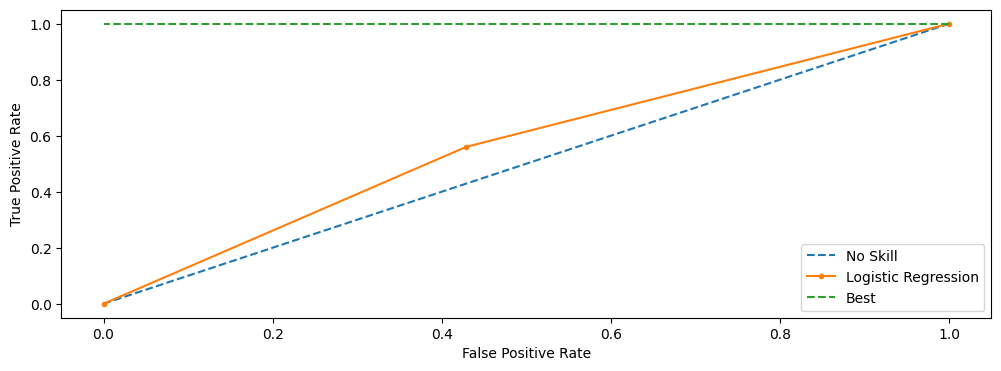

In [25]:
plot_roc_curve(Y_test,Y_pred_tuned)

<Figure size 1200x600 with 0 Axes>

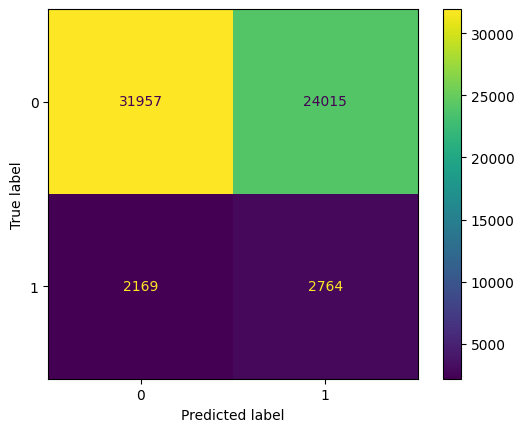

In [26]:
display_confusion_matrix(Y_test,Y_pred_tuned)

<h3> Third Approach - Computing optimal class weights</h3>
<p>  Before sampling, we can predict class probabilities instead of class labels and compute the weights of individual classes by thresholding. <b>The goal is to experiment with different thresholds and assign labels according to the best threshold.</b><br>
    For example, let's assume that the threshold = 0.5.<br> 
    Any probability less than 0.5 would be assigned to class 0 and greater than 0.5 would be class 1. Instead of setting 0.5 as the threshold, we will try different values to see how threshold will return the optimal F1 score.<br><br>
    Additionally, Geometric Mean and  Youden’s J statistic have been used to identify the best threshold value for an ROC curve.<br><br>

Here's a sneak peek into how G-Mean and J Statistic are computed:<br>
> G-Mean = sqrt(Sensitivity * Specificity), where:<br>
>> Sensitivity = True Positives / (True Positives + False Negatives) = True Positive Rate<br>
>> Specificity = True Negatives / (False Positives + True Negatives) = 1 - False Positive Rate<br>
    
> J Statistic = Sensitivity + Specificity – 1, (OR), True Positive Rate - False Positive Rate

For more information, please refer Blogs 4 and 5 with other resources.
</p>

<h3> Optimum threshold for ROC curve - Steps to follow: </h3>
<p> 
    <ol>
        <li> Split the original dataset into train and test sets. </li>
        <li> Build a classifier and predict probabilities. </li>
        <li> For each threshold, compute the class labels and the F1 score. </li>
        <li> Identify the threshold for which F1 score is highest. </li>
    </ol>
</p>

In [27]:
def convert_probs_to_labels(threshold,class_prob):
    return (class_prob>=threshold).astype('int') 

In [28]:
def perform_roc_thresholding(classifier,X_test):
    Y_pred_tuned_probs = classifier.predict_proba(X_test)
    predicted_probs = Y_pred_tuned_probs[:,1]
    fpr,tpr,thresholds = metrics.roc_curve(Y_test, predicted_probs)
    gmeans = np.sqrt(tpr * (1-fpr))
    
    return (fpr,tpr,thresholds,gmeans,predicted_probs)

In [29]:
fpr,tpr,thresholds,gmeans_logit,predicted_probs_logit = perform_roc_thresholding(logit_clf_tuned,X_test)

In [31]:
ix = np.argmax(gmeans_logit)
best_threshold = thresholds[ix]
best_gmeans = gmeans_logit[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_threshold, best_gmeans))

Best Threshold=0.495235, G-Mean=0.566


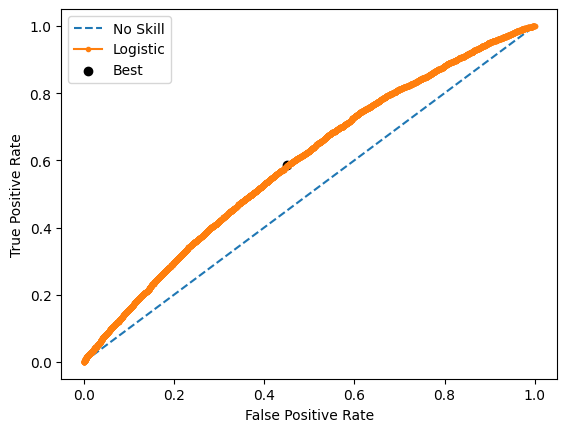

In [32]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [33]:
Y_pred_optimal_logit = pd.Series(convert_probs_to_labels(best_threshold,predicted_probs_logit))

In [34]:
print(metrics.classification_report(Y_test,Y_pred_optimal_logit))

              precision    recall  f1-score   support

           0       0.94      0.55      0.69     55972
           1       0.10      0.58      0.17      4933

    accuracy                           0.55     60905
   macro avg       0.52      0.57      0.43     60905
weighted avg       0.87      0.55      0.65     60905



In [83]:
print(metrics.recall_score(Y_test,Y_pred_optimal_logit,average='weighted'))

0.5516624250882523


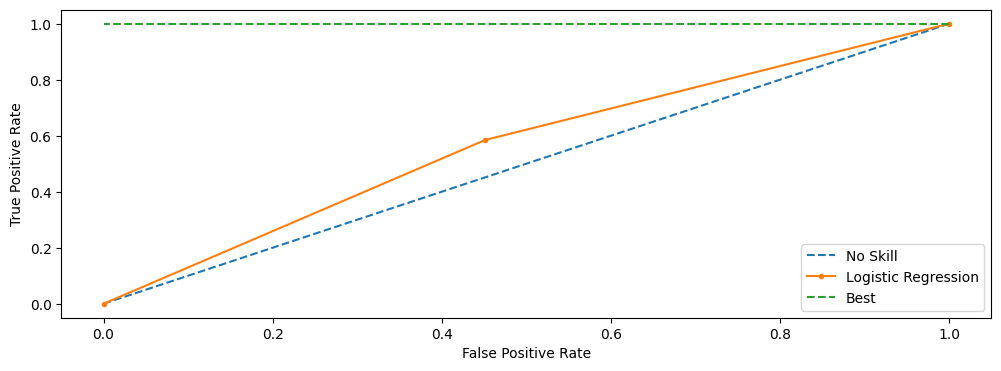

In [69]:
plot_roc_curve(Y_test,Y_pred_optimal_logit)

<Figure size 1200x600 with 0 Axes>

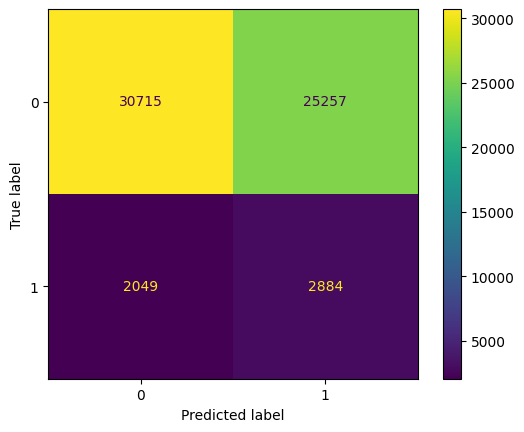

In [70]:
display_confusion_matrix(Y_test,Y_pred_optimal_logit)

<h3> Optimum threshold - Direct calculation </h3>

In [35]:
def compute_optimal_threshold(predicted_probs):
    best_f1_score = -np.inf
    best_threshold = -np.inf
    for threshold in np.arange(0,1,0.001):
        Y_pred_threshold = convert_probs_to_labels(threshold,predicted_probs)
        f1_score = metrics.f1_score(Y_test,Y_pred_threshold)
        if f1_score > best_f1_score:
            best_f1_score = f1_score 
            best_threshold = threshold    
    
    return (best_f1_score, best_threshold)

In [36]:
best_f1_score, best_threshold = compute_optimal_threshold(predicted_probs_logit)

In [37]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,predicted_probs_logit))

In [38]:
print(metrics.classification_report(Y_test,Y_pred_best_threshold))

              precision    recall  f1-score   support

           0       0.93      0.66      0.77     55972
           1       0.11      0.47      0.17      4933

    accuracy                           0.64     60905
   macro avg       0.52      0.56      0.47     60905
weighted avg       0.87      0.64      0.72     60905



In [84]:
print(metrics.recall_score(Y_test,Y_pred_best_threshold,average='weighted'))

0.8227895903456203


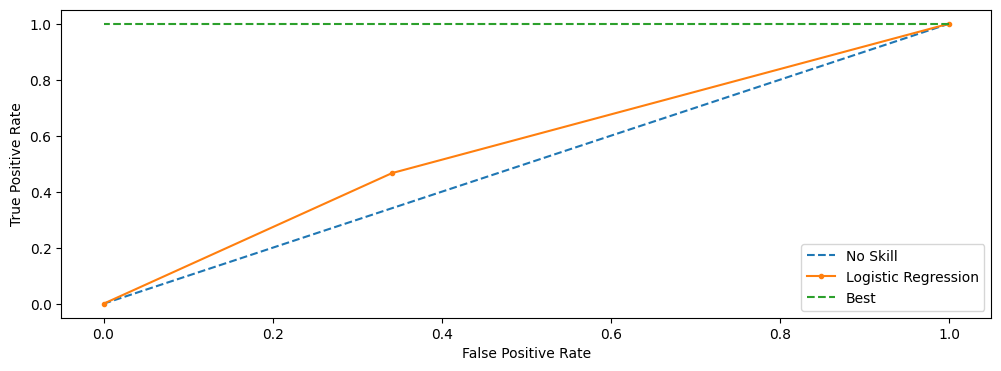

In [39]:
plot_roc_curve(Y_test,Y_pred_best_threshold)

<Figure size 1200x600 with 0 Axes>

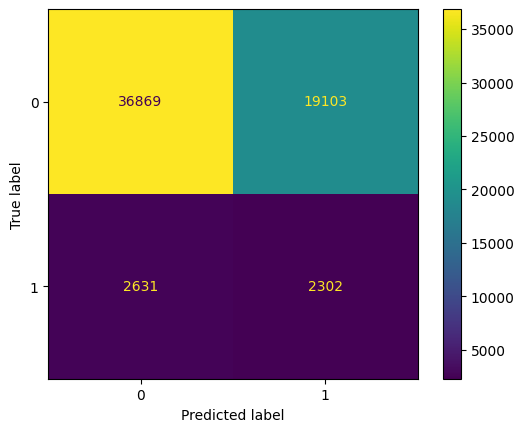

In [40]:
display_confusion_matrix(Y_test,Y_pred_best_threshold)

<h4> Till now, we now not applied any sampling technique, but tried different methods on the original data. It can be seen that the logistic regression classifier has not improved much. Now, let's build ensemble models like HistGradientBoostingClassifier and XGBoost.</h4>

In [41]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [42]:
hgb_clf = HistGradientBoostingClassifier(class_weight='balanced').fit(X_train,Y_train)

In [43]:
Y_pred_hgb = hgb_clf.predict(X_test)

In [44]:
print(metrics.classification_report(Y_test,Y_pred_hgb))

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     55972
           1       0.17      0.67      0.27      4933

    accuracy                           0.70     60905
   macro avg       0.56      0.69      0.54     60905
weighted avg       0.90      0.70      0.77     60905



In [85]:
print(metrics.recall_score(Y_test,Y_pred_hgb,average='weighted'))

0.7027994417535506


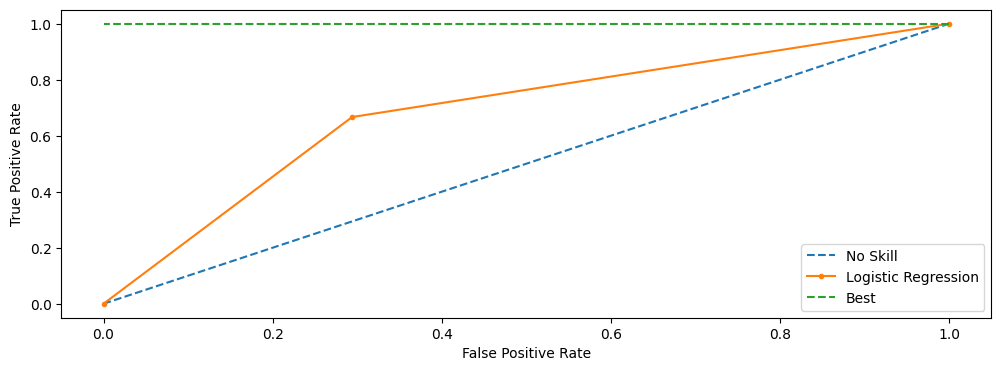

In [45]:
plot_roc_curve(Y_test,Y_pred_hgb)

<Figure size 1200x600 with 0 Axes>

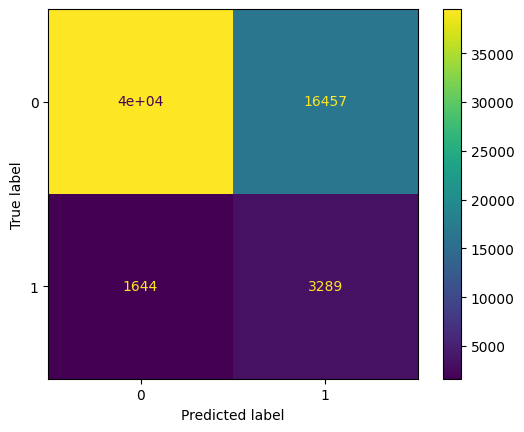

In [46]:
display_confusion_matrix(Y_test,Y_pred_hgb)

<h3> Tuning the HistGradientBoosting classifier </h3>

In [57]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        'learning_rate':trial.suggest_float('learning_rate',1e-3,1),
        'max_iter':trial.suggest_int('max_iter',100,500),
        'max_depth':trial.suggest_int('max_depth',10,100),
        'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',10,50),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',10,100),
        'class_weight':'balanced'
    }
    hgb_clf_tuned = HistGradientBoostingClassifier(**param).fit(X_train,Y_train)
    Y_pred_tuned = hgb_clf_tuned.predict(X_test)
    recall = metrics.recall_score(Y_test,Y_pred_tuned)
    return recall 

In [58]:
study = optuna.create_study(direction = 'maximize')

In [59]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 100)
print('Hist GB Best Parameters:',study.best_trial.params)
print('Best recall score:',study.best_value)

Hist GB Best Parameters: {'learning_rate': 0.018066075962691587, 'max_iter': 355, 'max_depth': 10, 'max_leaf_nodes': 11, 'min_samples_leaf': 31}
Best recall score: 0.6801135211838638


In [60]:
best_params = study.best_trial.params

In [61]:
hgb_clf_tuned = HistGradientBoostingClassifier(**best_params).fit(X_train,Y_train)

In [62]:
Y_pred_tuned_hbg = hgb_clf_tuned.predict(X_test)

In [63]:
print(metrics.classification_report(Y_test,Y_pred_tuned_hbg))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55972
           1       0.66      0.01      0.01      4933

    accuracy                           0.92     60905
   macro avg       0.79      0.50      0.49     60905
weighted avg       0.90      0.92      0.88     60905



In [87]:
print(metrics.recall_score(Y_test,Y_pred_tuned_hbg,average='weighted'))

0.9192841310237255


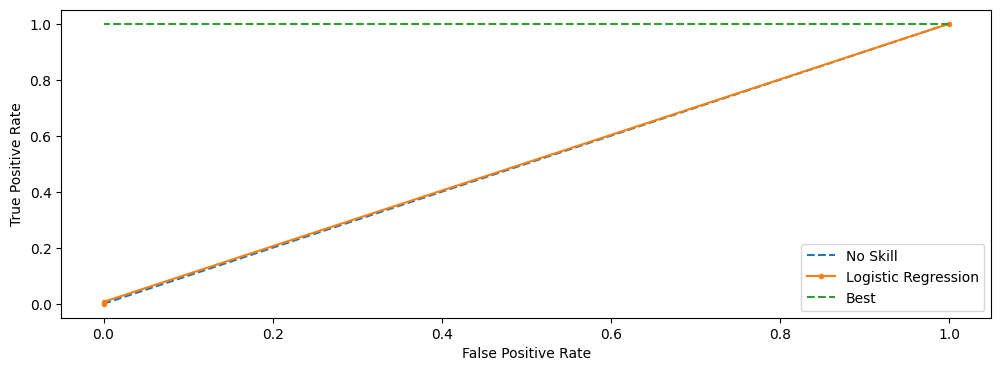

In [64]:
plot_roc_curve(Y_test,Y_pred_tuned_hbg)

<Figure size 1200x600 with 0 Axes>

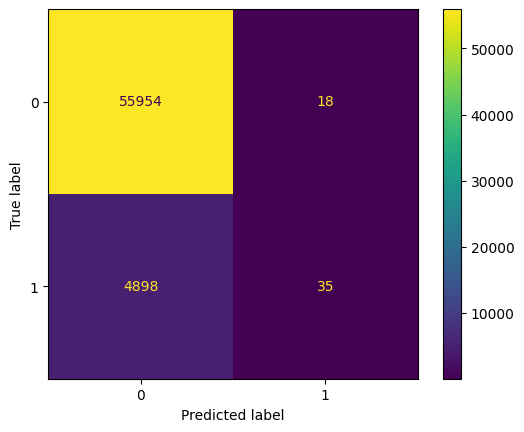

In [65]:
display_confusion_matrix(Y_test,Y_pred_tuned_hbg)

<h4> Repeating the thresholding operation </h4>

<h4> Starting with the optimal ROC threshold </h4>

In [66]:
fpr_hgb,tpr_hgb,thresholds_hgb,gmeans_hgb,predicted_probs_hgb = perform_roc_thresholding(hgb_clf_tuned,X_test)

In [67]:
ix = np.argmax(gmeans_hgb)
best_threshold = thresholds_hgb[ix]
best_gmeans = gmeans_hgb[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_threshold, best_gmeans))

Best Threshold=0.078225, G-Mean=0.685


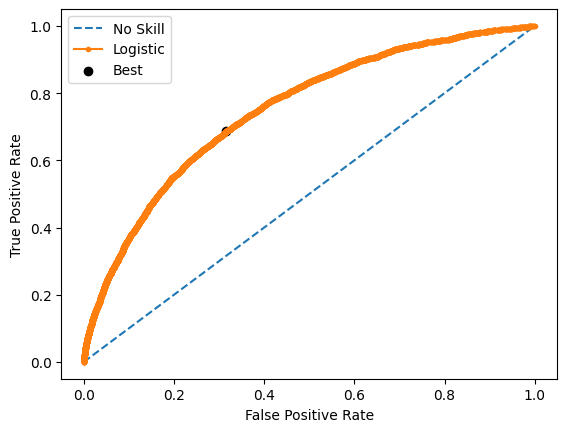

In [68]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_hgb, tpr_hgb, marker='.', label='Logistic')
plt.scatter(fpr_hgb[ix], tpr_hgb[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [71]:
Y_pred_optimal_hgb = pd.Series(convert_probs_to_labels(best_threshold,predicted_probs_hgb))

In [72]:
print(metrics.classification_report(Y_test,Y_pred_optimal_hgb))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     55972
           1       0.16      0.69      0.26      4933

    accuracy                           0.68     60905
   macro avg       0.56      0.69      0.53     60905
weighted avg       0.90      0.68      0.76     60905



In [88]:
print(metrics.recall_score(Y_test,Y_pred_optimal_hgb,average='weighted'))

0.6840817666858222


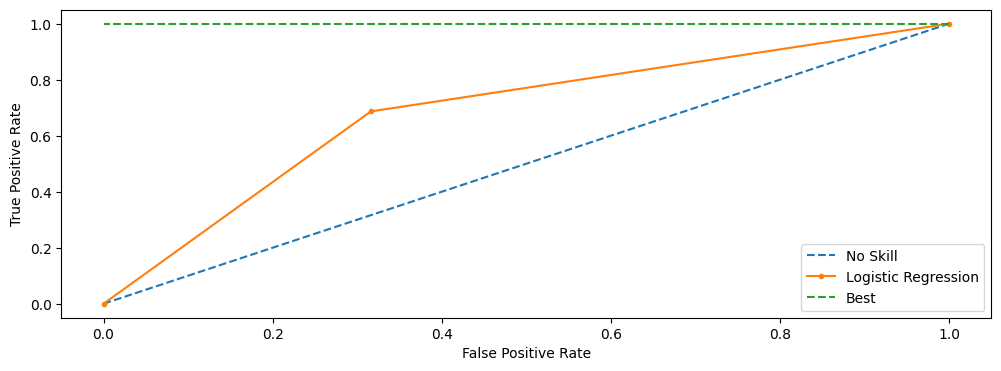

In [73]:
plot_roc_curve(Y_test,Y_pred_optimal_hgb)

<Figure size 1200x600 with 0 Axes>

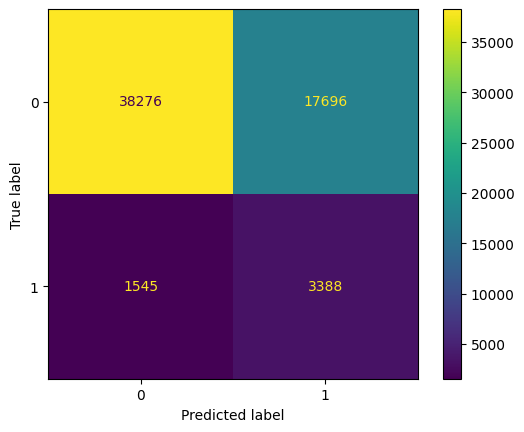

In [74]:
display_confusion_matrix(Y_test,Y_pred_optimal_hgb)

In [75]:
best_f1_score, best_threshold = compute_optimal_threshold(predicted_probs_hgb)

In [76]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,predicted_probs_hgb))

In [77]:
print(metrics.classification_report(Y_test,Y_pred_best_threshold))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     55972
           1       0.22      0.46      0.30      4933

    accuracy                           0.82     60905
   macro avg       0.58      0.66      0.60     60905
weighted avg       0.89      0.82      0.85     60905



In [89]:
print(metrics.recall_score(Y_test,Y_pred_best_threshold,average='weighted'))

0.8227895903456203


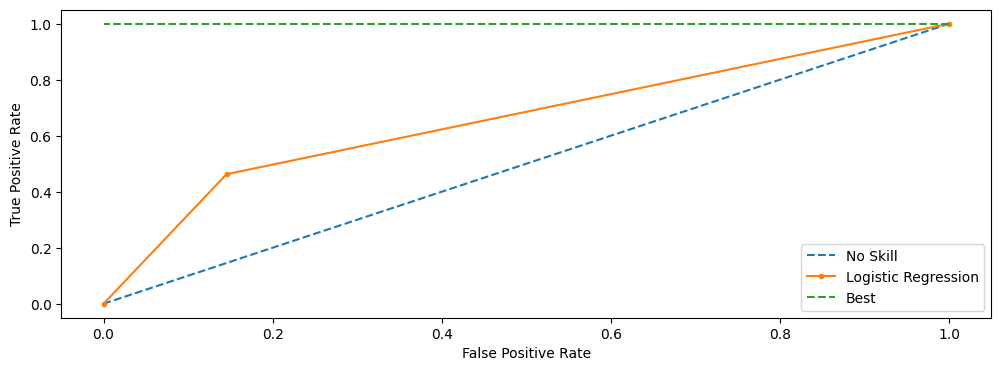

In [78]:
plot_roc_curve(Y_test,Y_pred_best_threshold)

<Figure size 1200x600 with 0 Axes>

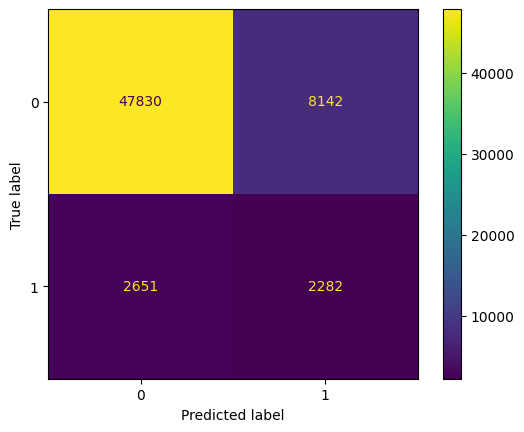

In [79]:
display_confusion_matrix(Y_test,Y_pred_best_threshold)

<h4> Building the XGBoost classifier </h4>

In [90]:
xgb_clf = XGBClassifier().fit(X_train,Y_train)

In [91]:
Y_pred_xgb = xgb_clf.predict(X_test)

In [92]:
print(metrics.classification_report(Y_test,Y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55972
           1       0.47      0.03      0.05      4933

    accuracy                           0.92     60905
   macro avg       0.70      0.51      0.51     60905
weighted avg       0.88      0.92      0.88     60905



In [93]:
print(metrics.recall_score(Y_test,Y_pred_xgb,average='weighted'))

0.9186930465479025


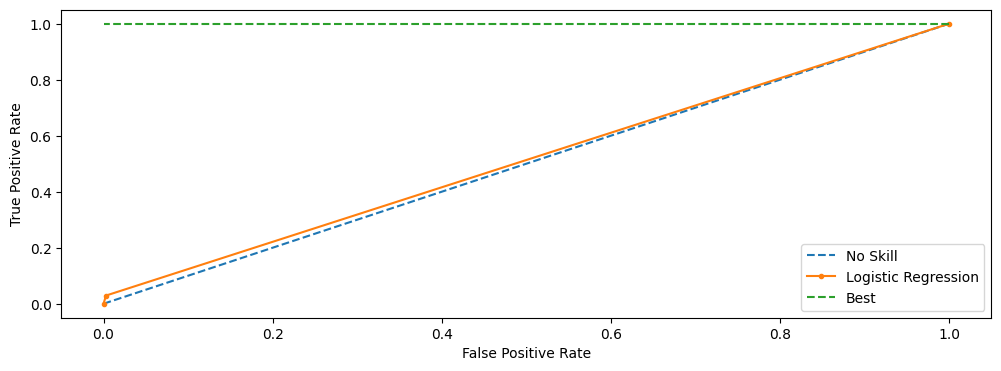

In [94]:
plot_roc_curve(Y_test,Y_pred_xgb)

<Figure size 1200x600 with 0 Axes>

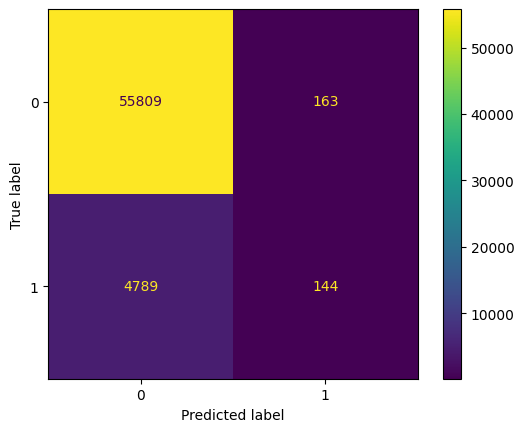

In [95]:
display_confusion_matrix(Y_test,Y_pred_xgb)

<h1> Starting with Oversampling </h1>

<h3> Approach 1 - Random Over Sampler </h3>

In [96]:
random_over_sampler = over_sampling.RandomOverSampler()

In [97]:
X_train_ros, Y_train_ros = random_over_sampler.fit_resample(X_train,Y_train)

In [98]:
Y_train_ros.value_counts()

TARGET
0    223886
1    223886
Name: count, dtype: int64

In [99]:
logit_clf_sampled = LogisticRegression().fit(X_train_ros,Y_train_ros)

In [100]:
Y_pred_sampled = logit_clf_sampled.predict(X_test)

In [101]:
print(metrics.classification_report(Y_test,Y_pred_sampled))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     55972
           1       0.10      0.40      0.16      4933

    accuracy                           0.65     60905
   macro avg       0.51      0.54      0.47     60905
weighted avg       0.86      0.65      0.73     60905



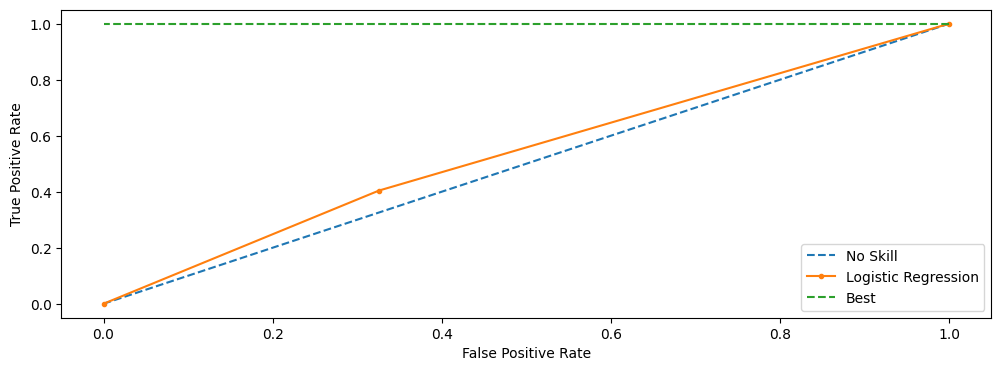

In [102]:
plot_roc_curve(Y_test,Y_pred_sampled)

<Figure size 1200x600 with 0 Axes>

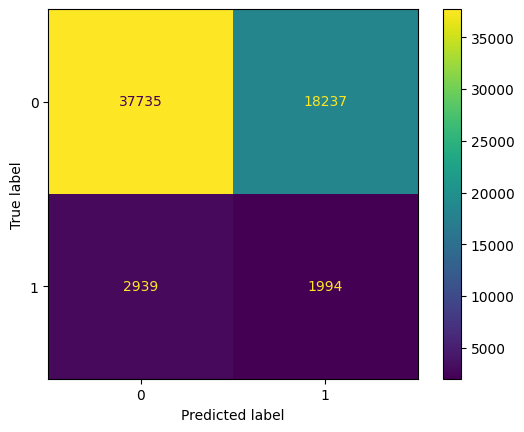

In [103]:
display_confusion_matrix(Y_test,Y_pred_sampled)